In [1]:
import os
import json
import cv2
import numpy as np
from skimage.color import label2rgb
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model


In [ ]:
import cv2
import numpy as np
import json

def load_images_and_masks(image_paths, json_paths, image_size=(256, 256), point_size=3):
    images = []
    masks = []

    for img_path, json_path in zip(image_paths, json_paths):
        img = cv2.imread(img_path)
        img = img / 255
        original_size = img.shape[:2] 
        img = cv2.resize(img, image_size)
        images.append(img)

       
        mask = np.zeros((image_size[0], image_size[1], 4), dtype=np.uint8)
        mask[:, :, 0] = 1 

        try:
            with open(json_path, 'r') as f:
                json_data = json.load(f)
        except Exception as e:
            print(f"Błąd odczytu JSON {json_path}: {e}")
            continue  

        if not isinstance(json_data, list):
            print(f"Nieprawidłowy format JSON w {json_path}, oczekiwano listy!")
            continue

        for item in json_data:
            if 'x' in item and 'y' in item and 'label_id' in item:
                x, y, label = int(item['x']), int(item['y']), int(item['label_id'])

                x = int((x / original_size[1]) * image_size[1])
                y = int((y / original_size[0]) * image_size[0])

                if 0 <= x < image_size[1] and 0 <= y < image_size[0]: 
                    if label == 1:
                        cv2.circle(mask, (x, y), point_size, (0, 1, 0, 0), -1)  
                    elif label == 2:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 1, 0), -1)  
                    elif label == 3:
                        cv2.circle(mask, (x, y), point_size, (0, 0, 0, 1), -1)  

        
        mask[:, :, 0] = (np.sum(mask[:, :, 1:], axis=-1) == 0).astype(np.uint8)

        masks.append(mask)

    return np.array(images), np.array(masks, dtype=np.float32)


def load_files(path):
    images = []
    jsons = []
    for root, _, files in os.walk(path):
        for file in files:
            if file.endswith(('.jpg', '.png')):
                images.append(os.path.join(root, file))
            elif file.endswith('.json'):
                jsons.append(os.path.join(root, file))
    return images, jsons

In [3]:
def conv_block(x, filters):
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(filters, (3, 3), activation='relu', padding='same')(x)
    return x

def max_pool(x):
    return layers.MaxPooling2D((2, 2))(x)

def upsample_block(x, skip, filters):
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(filters, (2, 2), activation='relu', padding='same')(x)
    x = layers.concatenate([x, skip])
    x = conv_block(x, filters)
    return x


In [4]:
def unet(input_shape=(256, 256, 3), output_channels=4, filterd_vector=[32, 64, 128, 256, 512]):
    inputs = layers.Input(input_shape)

    conv1 = conv_block(inputs, filterd_vector[0])
    pool1 = max_pool(conv1)

    conv2 = conv_block(pool1, filterd_vector[1])
    pool2 = max_pool(conv2)

    conv3 = conv_block(pool2, filterd_vector[2])
    pool3 = max_pool(conv3)

    conv4 = conv_block(pool3, filterd_vector[3])
    pool4 = max_pool(conv4)

    conv5 = conv_block(pool4, filterd_vector[4])

    up6 = upsample_block(conv5, conv4, filterd_vector[3])
    up7 = upsample_block(up6, conv3, filterd_vector[2])
    up8 = upsample_block(up7, conv2, filterd_vector[1])
    up9 = upsample_block(up8, conv1, filterd_vector[0])

    outputs = layers.Conv2D(output_channels, (1, 1), activation='softmax')(up9)

    model = models.Model(inputs, outputs)
    return model

In [5]:
train_images_paths, train_json = load_files('SHIDC-B-Ki-67/bare images/Train')
test_images_paths, test_json = load_files('SHIDC-B-Ki-67/bare images/Test')
X_train, Y_train = load_images_and_masks(train_images_paths, train_json)
X_test, Y_test = load_images_and_masks(test_images_paths, test_json)
X_train_final, X_val, Y_train_final, Y_val = train_test_split(
    X_train, Y_train, test_size=0.2, random_state=42
)

print(f"Dane treningowe: obrazy {X_train.shape}, maski {Y_train.shape}")
print(f"Dane testowe: obrazy {X_test.shape}, maski {Y_test.shape}")



Dane treningowe: obrazy (1656, 256, 256, 3), maski (1656, 256, 256, 4)
Dane testowe: obrazy (700, 256, 256, 3), maski (700, 256, 256, 4)


In [6]:
model_dir = "best_model"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [7]:
pred_mask_dir = "predicted_masks"
if not os.path.exists(pred_mask_dir):
    os.makedirs(pred_mask_dir)

model = unet(output_channels=4)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy', 
    metrics=['accuracy']
)

checkpoint = ModelCheckpoint(
    filepath=os.path.join(model_dir, "unet_best_model.h5"),  
    monitor="val_accuracy",  
    save_best_only=True,  
    mode="max",  
    verbose=1
)

history = model.fit(
    X_train_final, Y_train_final,
    epochs=50, batch_size=24,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint]
    )

K.clear_session() 

Epoch 1/50
56/56 [==============================] - ETA: 0s - loss: 0.2585 - accuracy: 0.8654
Epoch 1: val_accuracy improved from -inf to 0.97128, saving model to best_model\unet_best_model.h5
56/56 [==============================] - 38s 456ms/step - loss: 0.2585 - accuracy: 0.8654 - val_loss: 0.0787 - val_accuracy: 0.9713
Epoch 2/50
56/56 [==============================] - ETA: 0s - loss: 0.0756 - accuracy: 0.9696
Epoch 2: val_accuracy did not improve from 0.97128
56/56 [==============================] - 20s 361ms/step - loss: 0.0756 - accuracy: 0.9696 - val_loss: 0.0695 - val_accuracy: 0.9713
Epoch 3/50
56/56 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9696
Epoch 3: val_accuracy did not improve from 0.97128
56/56 [==============================] - 20s 361ms/step - loss: 0.0719 - accuracy: 0.9696 - val_loss: 0.0685 - val_accuracy: 0.9713
Epoch 4/50
56/56 [==============================] - ETA: 0s - loss: 0.0694 - accuracy: 0.9696
Epoch 4: val_accuracy did n

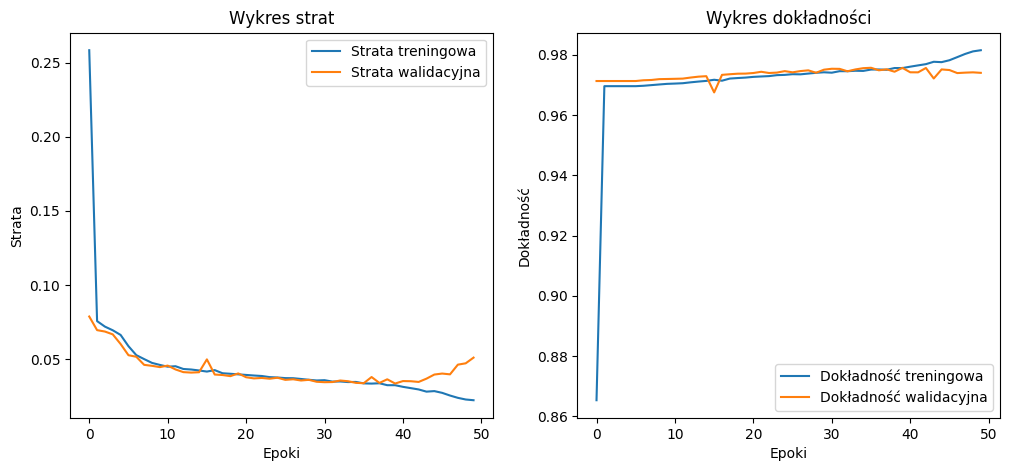

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.title('Wykres strat')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.title('Wykres dokładności')
plt.legend()

plt.show()

1/1 [==============================] - 1s 855ms/step


Text(0.5, 1.0, 'Prawdziwa maska')

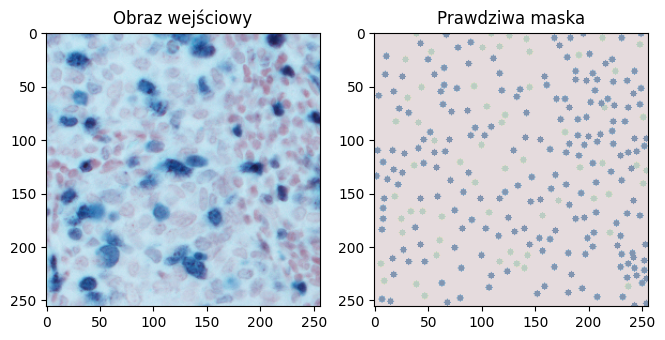

In [9]:
idx = random.randint(0, len(X_test) - 1)
test_img = X_test[idx:idx+1]  
true_mask = Y_test[idx] 
pred_mask = model.predict(test_img)[0]
plt.figure(figsize=(12, 5))
plt.subplot(1, 3, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")
plt.subplot(1, 3, 2)
plt.imshow(true_mask[:, :, 0], cmap='Reds', alpha=0.5) 
plt.imshow(true_mask[:, :, 1], cmap='Greens', alpha=0.5)
plt.imshow(true_mask[:, :, 2], cmap='Blues', alpha=0.5)  
plt.title("Prawdziwa maska")


1/1 [==============================] - 0s 16ms/step


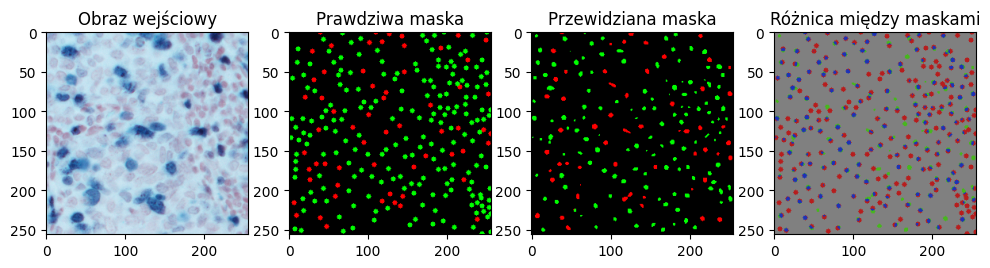

In [13]:
import random
import os
import cv2
import numpy as np
from skimage.color import label2rgb
import matplotlib.pyplot as plt

custom_colors = {
    0: [0, 0, 0],  # Tło - czarny
    1: [255, 0, 0], # Pozytywne - czerwony
    2: [0, 255, 0], # Negatywne - zielony
    3: [0, 0, 255]  # TIL - niebieski 
}

def compute_mask_difference(true_mask, pred_mask):
    diff_mask = np.zeros((*true_mask.shape, 3), dtype=np.uint8)

    true_mask_bin = (true_mask > 0).astype(np.uint8)
    pred_mask_bin = (pred_mask > 0).astype(np.uint8)

    # False Positives – Model przewidział, ale nie ma w ground truth (Zielony)
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 1)] = [71, 183, 29]

    # False Negatives – Model nie przewidział, ale ground truth istnieje (Czerwony)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 0)] = [183, 29, 29]

    # True Positives – Model dobrze przewidział (Niebieski)
    diff_mask[(true_mask_bin == 1) & (pred_mask_bin == 1)] = [29, 50, 183]

    # Tło – jeśli żaden z warunków nie został spełniony, ustaw szary kolor
    diff_mask[(true_mask_bin == 0) & (pred_mask_bin == 0)] = [128, 128, 128]

    return diff_mask

def apply_custom_colors(mask, colors):
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in colors.items():
        colored_mask[mask == label] = color
    return colored_mask


test_img = X_test[idx:idx+1]  
true_mask = np.argmax(Y_test[idx], axis=-1)
pred_mask = np.argmax(model.predict(test_img)[0], axis=-1)


true_mask_colored = apply_custom_colors(true_mask, custom_colors)
pred_mask_colored = apply_custom_colors(pred_mask, custom_colors)
mask_diff_colored = compute_mask_difference(true_mask, pred_mask)

plt.figure(figsize=(12, 5))

plt.subplot(1, 4, 1)
plt.imshow(test_img[0])
plt.title("Obraz wejściowy")

plt.subplot(1, 4, 2)
plt.imshow(true_mask_colored)
plt.title("Prawdziwa maska")

plt.subplot(1, 4, 3)
plt.imshow(pred_mask_colored)
plt.title("Przewidziana maska")

plt.subplot(1, 4, 4)
plt.imshow(mask_diff_colored)
plt.title("Różnica między maskami")
plt.show()


In [11]:
def test_model_performance(model, X_test, Y_test, threshold=0.5):
    Y_pred = model.predict(X_test)
    

    Y_pred_bin = (Y_pred > threshold).astype(np.uint8)
    

    iou_scores = []
    for class_idx in range(Y_test.shape[-1]): 
        intersection = np.logical_and(Y_test[..., class_idx], Y_pred_bin[..., class_idx]).sum()
        union = np.logical_or(Y_test[..., class_idx], Y_pred_bin[..., class_idx]).sum()
        
        iou = intersection / union if union > 0 else 0
        iou_scores.append(iou)

    correct_classifications = np.sum(Y_test == Y_pred_bin)
    total_pixels = np.prod(Y_test.shape)
    classification_accuracy = correct_classifications / total_pixels

    class_names = ["Pozytywne", "Negatywne", "TIL", "Tło"]
    print("\n Wyniki modelu na zbiorze testowym:")
    for i, class_name in enumerate(class_names):
        print(f"{class_name}: IoU = {iou_scores[i] * 100:.2f}%")

    print(f"\n Ogólna dokładność klasyfikacji: {classification_accuracy * 100:.2f}%")


my_model = load_model("./best_model/unet_best_model.h5")
test_model_performance(my_model, X_test, Y_test)

22/22 [==============================] - 10s 301ms/step

 Wyniki modelu na zbiorze testowym:
Pozytywne: IoU = 97.37%
Negatywne: IoU = 33.76%
TIL: IoU = 26.48%
Tło: IoU = 0.00%

 Ogólna dokładność klasyfikacji: 98.69%
